## Libraries

In [2]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import random
from copy import deepcopy

## Environment implementation

In [3]:
# ---------------------------
# Environment as describe in prior works
# ---------------------------
class ChainWalk:
    def __init__(self, n=50):
        self.n = n
        self.states = list(range(n))
        # transitions: 2 actions: left(0), right(1)
        # success prob 0.7, stay 0.1, reverse 0.2 (paper)
        self.P = self._build_P()
        self.r = np.zeros(n)
        self.r[10] = 1.0
        self.r[40] = -1.0

    def _build_P(self):
        n = self.n
        P = {}
        for a in [0,1]:
            P[a] = np.zeros((n,n))

        for s in range(self.n):
            for a in [0,1]:
                if a==0:
                    tgt = (s-1) % self.n
                    rev = (s+1) % self.n
                else:
                    tgt = (s+1) % self.n
                    rev = (s-1) % self.n
                P[a][s,tgt] += 0.7
                P[a][s,s] += 0.1
                P[a][s,rev] += 0.2

        return P

class CliffWalk:
    def __init__(self):
        """
        CliffWalk environment as described in:
        "PID Accelerated Temporal Difference Algorithms" (Bedaywi et al., RLC 2024).
        https://www.sologen.net/papers/PID-VI(ICML2021)(extended).pdf

        This is a 6×6 gridworld where an agent must navigate from the start state (top-left)
        to the goal state (top-right) while avoiding cliffs. The environment is stochastic:
        actions succeed with 0.9 probability and fail (random direction) with 0.1 probability.

        States:
        - 36 states (6 rows × 6 columns), indexed as `s = row * cols + col`.
        - Start: (0, 0)
        - Goal: (0, 5), reward = +20
        - Cliffs: Rows 1, 3, 5 (0-indexed), columns 1–4 (0-indexed), with rewards:
            - Row 1: -32 (top cliffs)
            - Row 3: -16 (middle cliffs)
            - Row 5: -8 (bottom cliffs)
        - All other states: reward = -1 (default)

        --------------------------------------------------
        # # # # # # # # #
        # S X X X X X E # X = Cliff (r=-32)
        # O O O O O O O #
        # O X X X X X O # X = Cliff (r=-16)
        # O O O O O O O #
        # O X X X X X O # X = Cliff (r=-8)
        # O O O O O O O #
        # # # # # # # # #

        S = Start, E = End (r=20), O = Safe path (r=-1)
        --------------------------------------------------

        Actions:
        - 0: Up
        - 1: Down
        - 2: Left
        - 3: Right

        Dynamics:
        - If the agent is in the goal or a cliff, it stays there (absorbing state).
        - Otherwise, transitions are stochastic (0.9 success, 0.1 random direction).
        - Attempting to move off the grid leaves the agent in place.

        Policy (for evaluation):
        - The paper uses a random walk policy (uniform action selection) for experiments.
        """
        # Initialisation
        self.rows = 6
        self.cols = 6
        self.n = self.rows * self.cols
        self.states = list(range(self.n))
        self.r = np.full(self.n, -1.0)  # default reward: -1

        # Define goal and cliffs
        goal_idx = 0 * self.cols + (self.cols - 1)  # top-right
        self.r[goal_idx] = 20.0 # winning reward: +20

        # Define cliffs (row 1, 3 and 5 / cols 1 to 4)
        cliff_row_rewards = [
            (1, -32), # top cliffs
            (3, -16), # middle cliffs
            (5, -8), # bottom cliffs
        ]
        for (row, reward) in cliff_row_rewards:  # rows with cliffs
            for col in range(1, self.cols - 1):  # columns with cliffs
                state = row * self.cols + col
                self.r[state] = reward

        self.P = self._build_P()

    def _build_P(self):
        n = self.n
        rows, cols = self.rows, self.cols
        P = {}
        actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up/down/left/right
        for a_idx in range(len(actions)):
            P[a_idx] = np.zeros((n, n))

        for r in range(rows):
            for c in range(cols):
                s = r * cols + c

                # Check absorbing states
                is_goal  = (r == 0 and c == cols - 1)
                is_cliff = (r in [1, 3, 5] and 1 <= c <= 4)

                if is_goal or is_cliff:
                    for a_idx in range(len(actions)):
                        P[a_idx][s, s] = 1.0
                    continue

                # Normal transitions
                for a_idx, (dr, dc) in enumerate(actions):
                    nr, nc = r + dr, c + dc

                    # Attempt to move off-grid → stays in place
                    if nr < 0 or nr >= rows or nc < 0 or nc >= cols:
                        P[a_idx][s, s] = 1.0
                        continue

                    # Success: go to intended direction (0.9)
                    tgt = nr * cols + nc
                    P[a_idx][s, tgt] += 0.9

                    # Failure: 0.1 split across other 3 directions
                    for b_idx, (br, bc) in enumerate(actions):
                        if b_idx == a_idx:
                            continue

                        rr, cc = r + br, c + bc
                        prob = 0.1 / 3.0

                        if rr < 0 or rr >= rows or cc < 0 or cc >= cols:
                            # Off-grid → stays in place
                            P[a_idx][s, s] += prob
                        else:
                            other = rr * cols + cc
                            P[a_idx][s, other] += prob

        return P


class Garnet:
    def __init__(self, n=50, m=3, b=5, seed=None):
        # n states, m actions, b next states per (s,a) uniformly chosen
        self.n=n; self.m=m; self.b=b
        rng = np.random.RandomState(seed)
        self.P = {a: np.zeros((n,n)) for a in range(m)}
        self.r = np.zeros(n)
        # choose 10 random states with reward uniform(0,1)
        good = rng.choice(n, size=10, replace=False)
        for s in good:
            self.r[s] = rng.rand()
        for s in range(n):
            for a in range(m):
                choices = rng.choice(n, size=b, replace=False)
                for c in choices:
                    self.P[a][s,c] = 1.0 / b

## Controller

In [68]:
class BaseController:
    def apply(self, br, V, Vprev, z):
        """Return delta to add to V (i.e. controller output)"""
        raise NotImplementedError

# baseline TD
class PController(BaseController):
    def __init__(self, kp=1.0): self.kp = kp
    def apply(self, br, V, Vprev, z): return self.kp * br

class PIDController(BaseController):
    def __init__(self, kp=1.0, ki=0.0, kd=0.0, alpha=0.05, beta=0.95):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.alpha = alpha
        self.beta = beta

    def apply(self, br, V, Vprev, Vprev2,  z):
        return (
            self.kp * br
            + self.ki * z
            + self.kd * (V - Vprev)
        )
    
    def grad_out(self):
        return 1        

class PI2DController(BaseController):
    def __init__(self, kp=1.0, ki=0.0, kd=0.0, kd2 = 0, alpha=0.05, beta=0.95):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.kd2 = kd2
        self.alpha = alpha
        self.beta = beta

    def apply(self, br, V, Vprev, Vprev2,  z):
        return (
            self.kp * br
            + self.ki * z
            + self.kd * (V - Vprev)
            + self.kd2 * (V - 2*Vprev + Vprev2)
        )        

    def grad_out(self):
        return 1

class PD2Controller(BaseController):
    def __init__(self, kp=1.0, kd1=0.0, kd2=0.0):
        self.kp=kp; self.kd1=kd1; self.kd2=kd2
        self.prev2 = None

    def apply(self, br, V, Vprev, z):
        if self.prev2 is None:
            self.prev2 = Vprev.copy()
        second = V - 2*Vprev + self.prev2
        out = self.kp*br + self.kd2*second + self.kd1*(V - Vprev)
        self.prev2 = Vprev.copy()
        return out

class SaturatingPID(PIDController):
    def __init__(self, kp=1.0, ki=0.0, kd=0.0, clip=1.0, **kwargs):
        super().__init__(kp,ki,kd,**kwargs)
        self.clip = clip
    def apply(self, br, V, Vprev, Vprev2,  z):
        self.out = super().apply(br, V, Vprev, Vprev2,  z)
        return np.clip(self.out, -self.clip, self.clip)
    
    def grad_out(self):
        mask = (np.abs(self.out) < self.clip).astype(float)
        return mask

class TanhPID(PIDController):
    def __init__(self, kp=1.0, ki=0.0, kd=0.0, clip=1.0, **kwargs):
        super().__init__(kp, ki, kd, **kwargs)
        self.clip = clip
        self.raw_out_km1 = None
        self.raw_out = None

    def apply(self, br, V, Vprev, Vprev2, z):
        if self.raw_out is not None:
            self.raw_out_km1 = self.raw_out.copy()
        self.raw_out = super().apply(br, V, Vprev, Vprev2, z)
        return self.clip * np.tanh(self.raw_out / self.clip)

    def grad_out(self):
        x = self.raw_out_km1 / self.clip
        return 1.0 - np.tanh(x)**2
    
class TanhPI2D(PI2DController):
    def __init__(self, kp=1.0, ki=0.0, kd=0.0, kd2 = 0.0, clip=1.0, **kwargs):
        super().__init__(kp, ki, kd, kd2, **kwargs)
        self.clip = clip
        self.raw_out = None

    def apply(self, br, V, Vprev, Vprev2, z):
        self.raw_out = super().apply(br, V, Vprev, Vprev2, z)
        return self.clip * np.tanh(self.raw_out / self.clip)

    def grad_out(self):
        x = self.raw_out / self.clip
        return 1.0 - np.tanh(x)**2


## Useful functions

In [61]:
# ---------------------------
# Policy and P^pi formation
# ---------------------------

def build_P_pi(P, policy):
    # P: dict action -> (n,n); policy: for each state distribution over action
    # returns n x n matrix P^pi
    actions = sorted(P.keys())
    n = P[actions[0]].shape[0]
    Ppi = np.zeros((n,n))
    for a in actions:
        # policy can be either deterministic mapping state->action index or
        if policy.ndim==1:
            # deterministic: policy[s] = a_index
            for s in range(n):
                if policy[s]==a:
                    Ppi[s,:] += P[a][s,:]
        else:
            # policy_probs: (n, m) with prob per action per state
            probs = policy[:,a]
            for s in range(n):
                Ppi[s,:] += probs[s] * P[a][s,:]
    return Ppi

# ---------------------------
# Utilities: compute A^pi_g and eigenvalues (PE case)
# ---------------------------

def compute_A_pi_g(Ppi, kp, ki, kd, alpha, beta):
    # Ppi: n x n transition matrix
    n = Ppi.shape[0]
    I = np.eye(n)
    A11 = (1 - kp + kd - ki*alpha)*I + (kp + ki*alpha)* (Ppi * gamma)
    A12 = beta * ki * I
    A13 = -kd * I
    A21 = (-alpha * I + gamma * alpha * Ppi)
    A22 = beta * I
    A23 = np.zeros((n,n))
    A31 = I
    A32 = np.zeros((n,n))
    A33 = np.zeros((n,n))
    top = np.hstack([A11, A12, A13])
    mid = np.hstack([A21, A22, A23])
    bot = np.hstack([A31, A32, A33])
    A = np.vstack([top, mid, bot])
    return A

def spectral_radius_info(A):
    eigs = la.eigvals(A)
    return eigs, max(abs(eigs))

## PID-TD Algorithm

In [62]:
def pid_vi_control(
    env,
    controller,        
    gamma=0.99,
    steps=500,
    eta=1e-6,
    update_params = True
):
    n = env.n
    actions = sorted(env.P.keys())
    m = len(actions)

    # Q flattened: shape (n*m,)
    dim = n * m

    # initialize
    Qkm3 = np.zeros(dim)
    Qkm2 = np.zeros(dim)
    Qkm1 = np.zeros(dim)
    Qk = np.zeros(dim)
    BRkm1 = np.zeros(n)

    zkm1 = np.zeros(dim)
    zk = np.zeros(dim)

    traj = []

    def greedy_policy(Q):
        Qmat = Q.reshape(n, m)
        return np.argmax(Qmat, axis=1)

    def build_P_pi_Q(Q):
        pi = greedy_policy(Q)
        return build_P_pi(env.P, pi)

    for k in range(steps):

        # greedy policy and induced transition
        Ppik = build_P_pi_Q(Qk)
        M = np.eye(dim) - gamma * np.kron(Ppik, np.eye(m))

        # Bellman optimality operator
        Qmat = Qk.reshape(n, m)
        Vnext = np.max(Qmat, axis=1)

        Tstar_Q = np.zeros_like(Qmat)
        for ai, a in enumerate(actions):
            Tstar_Q[:, ai] = env.r + gamma * env.P[a] @ Vnext

        Tstar_Q = Tstar_Q.reshape(dim)

        # Bellman residual
        BRk = Tstar_Q - Qk

        # integrator
        if hasattr(controller, 'alpha'):
            zk = controller.beta * zkm1 + controller.alpha * BRk

        # PID update
        Qkp1 = Qk + controller.apply(BRk, Qk, Qkm1, Qkm2, zk)

        if k > 2 and update_params:

            grad_out = controller.grad_out()

            # gradients (control case)
            grad_kp = -M @ (grad_out * BRkm1)
            grad_kd = -M @ (grad_out * (Qkm1 - Qkm2))
    
            
            if hasattr(controller, 'kd2'):
                grad_kd2 = -M @ (grad_out*(Qkm1 - 2*Qkm2 + Qkm3))
            if hasattr(controller, 'alpha'):
                grad_ki = -M @ (grad_out*zk)
                grad_alpha = -controller.ki * M @ BRkm1
                grad_beta = -controller.ki * M @ zkm1

            # gradient descent on ||BR*||^2
            denom = np.dot(BRkm1, BRkm1) + 1e-20

            controller.kp -= eta * np.dot(grad_kp, BRk) / denom
            controller.kd -= eta * np.dot(grad_kd, BRk) / denom
            
            try:
                kd
            except:
                kd = []
            kd.append(controller.kd)                            

            if hasattr(controller, 'kd2'):
                controller.kd2 -= eta * np.dot(grad_kd2, BRk) / denom
            if hasattr(controller, 'alpha'):
                controller.ki -= eta * np.dot(grad_ki, BRk) / denom
                # controller.alpha -= eta * np.dot(grad_alpha, BRk) / denom
                # controller.beta -= eta * np.dot(grad_beta, BRk) / denom

        # shift memory
        Qkm3 = Qkm2.copy()
        Qkm2 = Qkm1.copy()
        Qkm1 = Qk.copy()
        Qk = Qkp1.copy()
        BRkm1 = BRk.copy()

        zkm1 = zk.copy()

        traj.append(np.linalg.norm(BRk))
    
    Qk = Qk.reshape(n, m)
    return {
        "Q": Qk,
        "V" : np.max(Qk, axis = 1),
        "traj": np.array(traj),
        "controller": controller,
    }

## Test


=== Running experiment on ChainWalk (control) ===
Spectral radius of A^pi_g: 0.9933197194487738
Top eigenvalues (some): [ 0.09682996+0.75759201j  0.09682996-0.75759201j  0.01507198+0.74909455j
  0.01507198-0.74909455j -0.06176261+0.73076597j -0.06176261-0.73076597j
 -0.13219504+0.70330362j -0.13219504-0.70330362j -0.19473802+0.66762135j
 -0.19473802-0.66762135j]


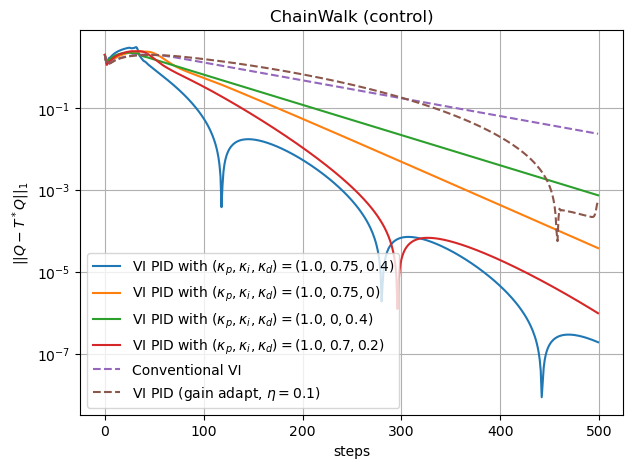


=== Running experiment on CliffWalk (control) ===
Spectral radius of A^pi_g: 0.981586954920539
Top eigenvalues (some): [-0.03401083+0.44940952j -0.03401083-0.44940952j -0.03400649+0.44940985j
 -0.03400649-0.44940985j  0.26998758+0.36104998j  0.26998758-0.36104998j
  0.2699892 +0.36104878j  0.2699892 -0.36104878j  0.03119139+0.44963072j
  0.03119139-0.44963072j]


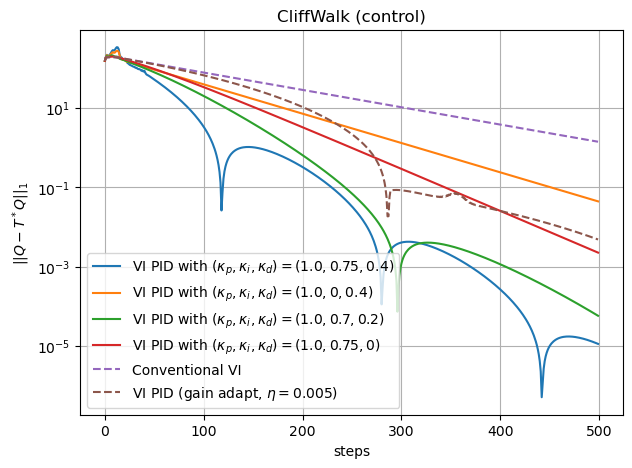


=== Running experiment on Garnet (control) ===
Spectral radius of A^pi_g: 0.9815869549205332
Top eigenvalues (some): [0.98158695+0.j         0.95573372+0.j         0.116572  +0.66718161j
 0.116572  -0.66718161j 0.17062347+0.63650955j 0.17062347-0.63650955j
 0.3035433 +0.55634298j 0.3035433 -0.55634298j 0.23265528+0.60678445j
 0.23265528-0.60678445j]


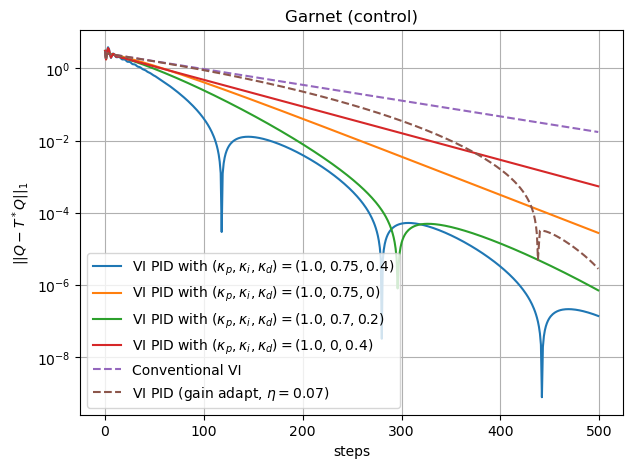

In [7]:
# global gamma for compute_A_pi_g function
global gamma
gamma = 0.99

def run_and_plot(
    env,
    env_name,
    eta = 1e-5
):
    
    print(f"\n=== Running experiment on {env_name} ===")

    # deterministic policy: always move left (per paper)
    policy = np.zeros(env.n, dtype=int)  # action 0 = left

    # build P^pi
    Ppi = build_P_pi(env.P, policy)

    # PID controller with roughly paper values
    pid_controller = PIDController(kp=1.0, ki=0.3, kd=0.2, alpha=0.05, beta=0.95)
    pid_controllers = set()
    pid_controllers.add(PIDController(kp=1.0, ki=0.75, kd=0, alpha=0.05, beta=0.95))
    pid_controllers.add(PIDController(kp=1.0, ki=0, kd=0.4, alpha=0.05, beta=0.95))
    pid_controllers.add(PIDController(kp=1.0, ki=0.75, kd=0.4, alpha=0.05, beta=0.95))
    pid_controllers.add(PIDController(kp=1.0, ki=0.7, kd=0.2, alpha=0.05, beta=0.95))
    # pid_controllers.add(PIDController(kp=1.2, ki=0, kd=0, alpha=0.05, beta=0.95))

    # compute A^pi_g and eigenvalues
    A = compute_A_pi_g(Ppi, kp=pid_controller.kp, ki=pid_controller.ki, kd=pid_controller.kd,
                       alpha=pid_controller.alpha, beta=pid_controller.beta)
    eigs, rho = spectral_radius_info(A)
    print("Spectral radius of A^pi_g:", rho)
    print("Top eigenvalues (some):", eigs[:10])
    
    plt.figure(figsize=(7, 5))

    # run PID-TD
    for pid_controller in pid_controllers:
        res = pid_vi_control(
            env,
            pid_controller,
            steps=500,
            gamma=gamma,
            eta = eta,
            update_params = False
        )
        plt.plot(res['traj'], label=f'VI PID with $(\kappa_p, \kappa_i, \kappa_d) = ({pid_controller.kp},{pid_controller.ki},{pid_controller.kd})$')

    vi_controller = PIDController(kp=1.0, ki=0, kd=0, alpha=0.05, beta=0.95)
    
    res_basic = pid_vi_control(
        env,
        vi_controller,
        steps=500,
        gamma=gamma,
        update_params=False,
    )


    res_update = pid_vi_control(
        env,
        vi_controller,
        steps=500,
        gamma=gamma,
        eta=eta,
        update_params=True,
    )    

    # ---- PLOT ----
    # plt.plot(res['traj'], label='PID-VI (gain adapt)')
    plt.plot(res_basic['traj'], "--" , label='Conventional VI')
    plt.plot(res_update['traj'], "--",  label=f'VI PID (gain adapt, $\eta = {eta}$)')
    plt.xlabel('steps')
    plt.ylabel('$||Q - T^*Q||_1$')
    plt.yscale('log')
    plt.title(env_name)
    plt.legend()
    plt.grid(True)
    plt.show()
    


# === RUN BOTH ENVIRONMENTS ===

# 1) ChainWalk
env_chain = ChainWalk(n=50)
run_and_plot(env_chain, "ChainWalk (control)", 0.1)

# 2) CliffWalk
env_cliff = CliffWalk()
run_and_plot(env_cliff, "CliffWalk (control)", eta = 5e-3)

# 3) Garnet
env_cliff = Garnet()
run_and_plot(env_cliff, "Garnet (control)", eta = 0.07)


=== Running experiment on ChainWalk (control) ===
Spectral radius of A^pi_g: 0.9933197194487738
Top eigenvalues (some): [ 0.09682996+0.75759201j  0.09682996-0.75759201j  0.01507198+0.74909455j
  0.01507198-0.74909455j -0.06176261+0.73076597j -0.06176261-0.73076597j
 -0.13219504+0.70330362j -0.13219504-0.70330362j -0.19473802+0.66762135j
 -0.19473802-0.66762135j]


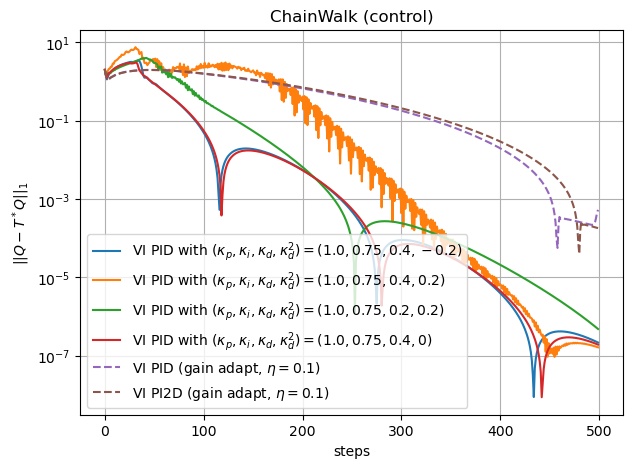


=== Running experiment on CliffWalk (control) ===
Spectral radius of A^pi_g: 0.981586954920539
Top eigenvalues (some): [-0.03401083+0.44940952j -0.03401083-0.44940952j -0.03400649+0.44940985j
 -0.03400649-0.44940985j  0.26998758+0.36104998j  0.26998758-0.36104998j
  0.2699892 +0.36104878j  0.2699892 -0.36104878j  0.03119139+0.44963072j
  0.03119139-0.44963072j]


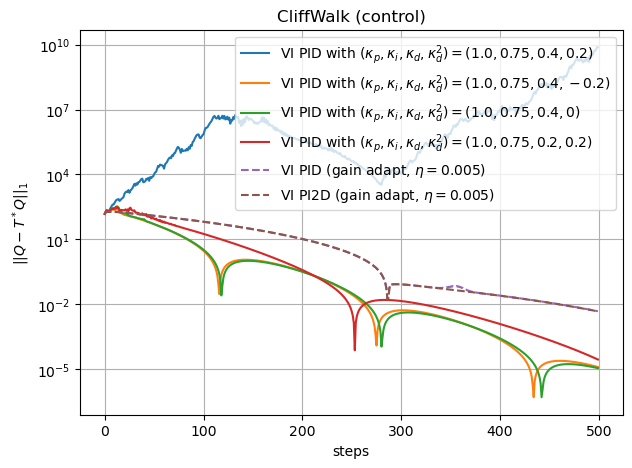


=== Running experiment on Garnet (control) ===
Spectral radius of A^pi_g: 0.981586954920535
Top eigenvalues (some): [0.09989052+0.43952573j 0.09989052-0.43952573j 0.98158695+0.j
 0.95573372+0.j         0.11498766+0.6699976j  0.11498766-0.6699976j
 0.23517463+0.6274161j  0.23517463-0.6274161j  0.29102695+0.58386506j
 0.29102695-0.58386506j]


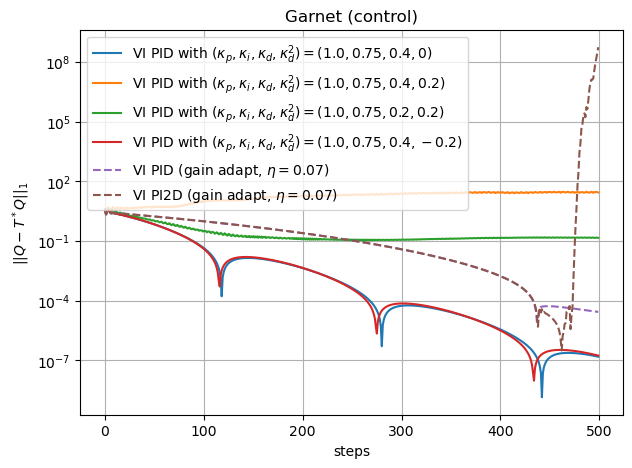

In [59]:
# global gamma for compute_A_pi_g function
global gamma
gamma = 0.99

def run_and_plot(
    env,
    env_name,
    eta = 1e-5
):
    print(f"\n=== Running experiment on {env_name} ===")

    # deterministic policy: always move left (per paper)
    policy = np.zeros(env.n, dtype=int)  # action 0 = left

    # build P^pi
    Ppi = build_P_pi(env.P, policy)

    # PID controller with roughly paper values
    pid_controller = PI2DController(kp=1.0, ki=0.3, kd=0.2, alpha=0.05, beta=0.95)
    pid_controllers = set()
    pid_controllers.add(PI2DController(kp=1.0, ki=0.75, kd=0.4, alpha=0.05, beta=0.95))
    pid_controllers.add(PI2DController(kp=1.0, ki=0.75, kd=0.4, kd2 = -0.2, alpha=0.05, beta=0.95))
    pid_controllers.add(PI2DController(kp=1.0, ki=0.75, kd=0.4, kd2 = 0.2, alpha=0.05, beta=0.95))
    pid_controllers.add(PI2DController(kp=1.0, ki=0.75, kd=0.2, kd2 = 0.2, alpha=0.05, beta=0.95))
    # pid_controllers.add(PIDController(kp=1.2, ki=0, kd=0, alpha=0.05, beta=0.95))

    # compute A^pi_g and eigenvalues
    A = compute_A_pi_g(Ppi, kp=pid_controller.kp, ki=pid_controller.ki, kd=pid_controller.kd,
                       alpha=pid_controller.alpha, beta=pid_controller.beta)
    eigs, rho = spectral_radius_info(A)
    print("Spectral radius of A^pi_g:", rho)
    print("Top eigenvalues (some):", eigs[:10])
    
    plt.figure(figsize=(7, 5))

    # run PID-TD
    for pid_controller in pid_controllers:
        res = pid_vi_control(
            env,
            pid_controller,
            steps=500,
            gamma=gamma,
            eta = eta,
            update_params = False
        )
        plt.plot(res['traj'], label=f'VI PID with $(\kappa_p, \kappa_i, \kappa_d, \kappa_d^2) = ({pid_controller.kp},{pid_controller.ki},{pid_controller.kd},{pid_controller.kd2})$')

    vi_controller = PIDController(kp=1.0, ki=0, kd=0, alpha=0.05, beta=0.95)
    
    res_basic = pid_vi_control(
        env,
        vi_controller,
        steps=500,
        gamma=gamma,
        update_params=True,
        eta = eta
    )

    vi_controller = PI2DController(kp=1.0, ki=0, kd=0, kd2 = 0, alpha=0.05, beta=0.95)

    res_update = pid_vi_control(
        env,
        vi_controller,
        steps=500,
        gamma=gamma,
        eta=eta,
        update_params=True,
    )    

    # ---- PLOT ----
    # plt.plot(res['traj'], label='PID-VI (gain adapt)')
    plt.plot(res_basic['traj'], "--" , label=f'VI PID (gain adapt, $\eta = {eta}$)')
    plt.plot(res_update['traj'], "--",  label=f'VI PI2D (gain adapt, $\eta = {eta}$)')
    plt.xlabel('steps')
    plt.ylabel('$||Q - T^*Q||_1$')
    plt.yscale('log')
    plt.title(env_name)
    plt.legend()
    plt.grid(True)
    plt.show()
    


# === RUN BOTH ENVIRONMENTS ===

# 1) ChainWalk
env_chain = ChainWalk(n=50)
run_and_plot(env_chain, "ChainWalk (control)", 0.1)

# 2) CliffWalk
env_cliff = CliffWalk()
run_and_plot(env_cliff, "CliffWalk (control)", eta = 5e-3)

# 3) Garnet
env_cliff = Garnet()
run_and_plot(env_cliff, "Garnet (control)", eta = 0.07)

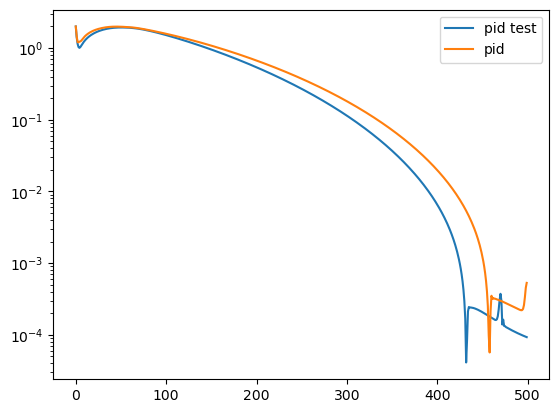

In [75]:
env = env_chain

vi_controller = TanhPID(kp=1.0, ki=0, kd=0, alpha=0.05, beta=0.95, clip = 0.4)

res = pid_vi_control(
    env,
    vi_controller,
    steps=500,
    gamma=gamma,
    eta = 0.1,
    update_params=True,
)

plt.plot(res['traj'], label = 'pid test')

# vi_controller = PI2DController(kp=1.0, ki=0.75, kd=0.4, kd2 = -0.2, alpha=0.05, beta=0.95)

# res = pid_vi_control(
#     env,
#     vi_controller,
#     steps=500,
#     gamma=gamma,
#     eta = 0.1,
#     update_params=False,
# )

# plt.plot(res['traj'], label = 'pi2d test')

# vi_controller = TanhPI2D(kp=1.0, ki=0, kd=0, alpha=0.05, beta=0.95, clip = 0.1)

# res = pid_vi_control(
#     env,
#     vi_controller,
#     steps=500,
#     gamma=gamma,
#     eta = 0.1,
#     update_params=True,
# )

# plt.plot(res['traj'], label = 'pi2d test')

vi_controller = PIDController(kp=1.0, ki=0, kd=0, alpha=0.05, beta=0.95)

res = pid_vi_control(
    env,
    vi_controller,
    steps=500,
    gamma=gamma,
    eta = 0.1,
    update_params=True,
)

plt.plot(res['traj'], label = 'pid')


# res = pid_vi_control(
#     env,
#     vi_controller,
#     steps=500,
#     gamma=gamma,
#     update_params=False,
# )

# plt.plot(res['traj'], '--')

plt.yscale('log')
plt.legend()
plt.show()